In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    mean_squared_error, r2_score, mean_absolute_error
)
import xgboost as xgb
from sklearn.calibration import CalibrationDisplay
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 10})
sns.set_style("whitegrid")
np.random.seed(42)

print("Ambiente configurado!")

✅ Ambiente configurado!


In [ ]:
df = pd.read_excel("bariatrica_sp_mg_2018_2023.xlsx")
print(f"✅ Dados carregados: {len(df)} registros")

# Verificar estatísticas de internação
print("\n📊 Estatísticas de DIAS_PERM:")
print(df['DIAS_PERM'].describe())

media_dias = df['DIAS_PERM'].mean()
mediana_dias = df['DIAS_PERM'].median()

print(f"\n Média de dias: {media_dias:.2f}")
print(f" Mediana de dias: {mediana_dias:.0f}")

# Testar dois limiares para classificação
limiar_3_dias = 3
limiar_media = media_dias

df['LONGA_3_DIAS'] = (df['DIAS_PERM'] > limiar_3_dias).astype(int)
df['LONGA_MEDIA'] = (df['DIAS_PERM'] > limiar_media).astype(int)

print(f"\n Casos >3 dias: {df['LONGA_3_DIAS'].sum()} ({df['LONGA_3_DIAS'].mean()*100:.1f}%)")
print(f" Casos >média ({media_dias:.1f} dias): {df['LONGA_MEDIA'].sum()} ({df['LONGA_MEDIA'].mean()*100:.1f}%)")

✅ Dados carregados: 1874 registros

📊 Estatísticas de DIAS_PERM:
count    1874.000000
mean        2.987727
std         2.399136
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        36.000000
Name: DIAS_PERM, dtype: float64

📌 Média de dias: 2.99
📌 Mediana de dias: 2

🎯 Casos >3 dias: 422 (22.5%)
🎯 Casos >média (3.0 dias): 759 (40.5%)


In [ ]:
# =============================================
# 2. Preparar Dados para Modelagem (VERSÃO PRÉ-OPERATÓRIA SEM VARIÁVEIS TEMPORAIS)
# =============================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Lista de CIDs de comorbidades relevantes para complicações pós-bariátrica
COMORBIDADES_CID = {
    'DIABETES': ['E10', 'E11', 'E13', 'E14'],
    'HIPERTENSAO': ['I10', 'I11', 'I12', 'I13', 'I15'],
    'DOENCA_CARDIACA': ['I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I30', 'I31', 'I33', 'I34', 'I35', 'I37', 'I38', 'I39', 'I40', 'I41', 'I42', 'I43', 'I44', 'I45', 'I46', 'I47', 'I48', 'I49', 'I50'],
    'DOENCA_PULMONAR': ['J40', 'J41', 'J42', 'J43', 'J44', 'J45', 'J46', 'J47'],
    'DOENCA_RENAL': ['N18', 'N19', 'I12', 'I13'],
    'TROMBOEMBOLISMO': ['I26', 'I80', 'I81', 'I82'],
    'APNEIA_SONO': ['G473'],
    'OBESIDADE_GRAVES': ['E660', 'E661', 'E662', 'E668', 'E669'],
    'DISLIPIDEMIA': ['E78'],
    'ACIDO_PEPTICO': ['K25', 'K26', 'K27', 'K28'],
    'DOENCA_HEPATICA': ['K70', 'K71', 'K72', 'K73', 'K74', 'K75', 'K76'],
    'DEPRESSAO': ['F32', 'F33', 'F34'],
    'ANSIEDADE': ['F41'],
    'OSTEOPOROSE': ['M80', 'M81', 'M82'],
    'ARTROSE': ['M15', 'M16', 'M17', 'M18', 'M19'],
}

def extrair_grupo_cid(codigo_cid):
    """Extrai os primeiros 3 caracteres do CID (ex: E110 → E11)"""
    if pd.isna(codigo_cid) or not isinstance(codigo_cid, str):
        return "DESCONHECIDO"
    return codigo_cid[:3] if len(codigo_cid) >= 3 else "DESCONHECIDO"

def criar_flags_comorbidades(df):
    """Cria flags binárias para comorbidades baseadas em DIAG_PRINC e DIAGSEC1-9"""
    df = df.copy()
    
    # Criar coluna de grupo CID para diagnóstico principal
    df['CID_PRINC_GRUPO'] = df['DIAG_PRINC'].apply(extrair_grupo_cid)
    
    # Criar colunas para diagnósticos secundários (concatenar todos)
    diag_sec_cols = [col for col in df.columns if col.startswith('DIAGSEC') and not col.startswith('TPDISEC')]
    df['DIAG_SECUNDARIOS'] = df[diag_sec_cols].fillna('').apply(
        lambda row: '|'.join([extrair_grupo_cid(x) for x in row if pd.notna(x) and x != '']), axis=1
    )
    
    # Criar flags para cada comorbidade
    for nome_comorbidade, cids in COMORBIDADES_CID.items():
        flag_col = f"PREOP_{nome_comorbidade}"
        # Verifica se o CID principal ou algum secundário está na lista
        df[flag_col] = df.apply(
            lambda row: int(
                row['CID_PRINC_GRUPO'] in cids or 
                any(cid in cids for cid in row['DIAG_SECUNDARIOS'].split('|') if cid != '')
            ),
            axis=1
        )
    
    return df

# Aplicar função de comorbidades
df = criar_flags_comorbidades(df)

# Selecionar features PRÉ-OPERATÓRIAS (disponíveis antes da cirurgia) 
features_candidatas = [
    # Demográficas
    'IDADE',            # Idade do paciente 
    'SEXO',             # Sexo (1=M, 3=F)
    'RACA_COR',         # Raça/cor
    
    # Clínicas (pré-existentes)
    'DIAG_PRINC',       # Diagnóstico principal (obesidade)
    'CID_PRINC_GRUPO',  # Grupo do CID principal
    
    # Flags de comorbidades (calculadas acima)
    'PREOP_DIABETES',
    'PREOP_HIPERTENSAO',
    'PREOP_DOENCA_CARDIACA',
    'PREOP_DOENCA_PULMONAR',
    'PREOP_DOENCA_RENAL',
    'PREOP_TROMBOEMBOLISMO',
    'PREOP_APNEIA_SONO',
    'PREOP_OBESIDADE_GRAVES',
    'PREOP_DISLIPIDEMIA',
    'PREOP_ACIDO_PEPTICO',
    'PREOP_DOENCA_HEPATICA',
    'PREOP_DEPRESSAO',
    'PREOP_ANSIEDADE',
    'PREOP_OSTEOPOROSE',
    'PREOP_ARTROSE',
    
    # Institucionais (conhecidas no agendamento)
    'NATUREZA',         # Natureza da internação (eletiva, urgência, etc.)
    'COMPLEX',          # Complexidade do hospital
    'FINANC',           # Tipo de financiamento (SUS, particular, etc.)
    
    # Socioeconômicas (se disponíveis)
    'INSTRU',           # Grau de instrução (se disponível)
    'NUM_FILHOS',       # Número de filhos (se disponível)
    
    # Estado (apenas para estratificação na divisão, NÃO como feature)
    'ESTADO_ORIGEM'     # MG ou SP
]

# Filtrar colunas existentes
features = [col for col in features_candidatas if col in df.columns]
X = df[features].copy()
y_reg = df['DIAS_PERM'].copy()  # Alvo para regressão

# Definir alvo de classificação: internação longa (>3 dias)
y_clf = (df['DIAS_PERM'] > 3).astype(int)

print(f"✅ Features selecionadas (pré-operatórias, sem variáveis temporais): {len(features)}")
print("📋 Lista de features:")
for f in features:
    print(f"  - {f}")

# Remover 'ESTADO_ORIGEM' de X (não deve ser usado como feature preditiva)
if 'ESTADO_ORIGEM' in X.columns:
    X = X.drop(columns=['ESTADO_ORIGEM'])

# Tratar valores ausentes
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].fillna('DESCONHECIDO')
    else:
        X[col] = X[col].fillna(X[col].median())

# Codificar variáveis categóricas
label_encoders = {}
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"\n✅ Dados preparados: {X.shape[0]} registros, {X.shape[1]} features")

# Dividir dados (estratificado por estado — apenas para garantir representatividade, não como feature)
X_train, X_test, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=df['ESTADO_ORIGEM']
)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42, stratify=df['ESTADO_ORIGEM']
)

print(f"✅ Divisão concluída: {len(X_train)} treino, {len(X_test)} teste")

✅ Features selecionadas (pré-operatórias, sem variáveis temporais): 26
📋 Lista de features:
  - IDADE
  - SEXO
  - RACA_COR
  - DIAG_PRINC
  - CID_PRINC_GRUPO
  - PREOP_DIABETES
  - PREOP_HIPERTENSAO
  - PREOP_DOENCA_CARDIACA
  - PREOP_DOENCA_PULMONAR
  - PREOP_DOENCA_RENAL
  - PREOP_TROMBOEMBOLISMO
  - PREOP_APNEIA_SONO
  - PREOP_OBESIDADE_GRAVES
  - PREOP_DISLIPIDEMIA
  - PREOP_ACIDO_PEPTICO
  - PREOP_DOENCA_HEPATICA
  - PREOP_DEPRESSAO
  - PREOP_ANSIEDADE
  - PREOP_OSTEOPOROSE
  - PREOP_ARTROSE
  - NATUREZA
  - COMPLEX
  - FINANC
  - INSTRU
  - NUM_FILHOS
  - ESTADO_ORIGEM

✅ Dados preparados: 1874 registros, 25 features
✅ Divisão concluída: 1499 treino, 375 teste


In [5]:
# ## 3. Treinar Modelos de Classificação (Comparar Limiares)

# %%
def treinar_modelos_classificacao(y_target, nome_alvo):
    print(f"\n🔍 Treinando modelos para alvo: {nome_alvo}")
    
    y_train = y_train_reg.copy() if y_target is y_reg else y_target.loc[y_train_reg.index]
    y_test = y_target.loc[y_test_reg.index]
    
    # XGBoost
    model_xgb = xgb.XGBClassifier(n_estimators=300, max_depth=6, random_state=42)
    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)
    y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]
    
    # Random Forest
    model_rf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    y_proba_rf = model_rf.predict_proba(X_test)[:, 1]
    
    # Rede Neural
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model_nn = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=1000, random_state=42)
    model_nn.fit(X_train_scaled, y_train)
    y_pred_nn = model_nn.predict(X_test_scaled)
    y_proba_nn = model_nn.predict_proba(X_test_scaled)[:, 1]
    
    # Métricas
    def get_metrics(y_true, y_pred, y_proba):
        auc = roc_auc_score(y_true, y_proba)
        report = classification_report(y_true, y_pred, output_dict=True)
        f1 = report['weighted avg']['f1-score']
        return auc, f1
    
    metrics = {}
    metrics['XGBoost'] = get_metrics(y_test, y_pred_xgb, y_proba_xgb)
    metrics['Random Forest'] = get_metrics(y_test, y_pred_rf, y_proba_rf)
    metrics['Rede Neural'] = get_metrics(y_test, y_pred_nn, y_proba_nn)
    
    # Melhor modelo
    melhor_modelo = max(metrics.keys(), key=lambda k: metrics[k][0])  # maior AUC
    melhor_auc = metrics[melhor_modelo][0]
    
    print(f"✅ Melhor AUC: {melhor_auc:.3f} ({melhor_modelo})")
    
    return {
        'metrics': metrics,
        'melhor_modelo': melhor_modelo,
        'melhor_auc': melhor_auc,
        'y_test': y_test,
        'y_pred_xgb': y_pred_xgb,
        'y_proba_xgb': y_proba_xgb,
        'y_pred_rf': y_pred_rf,
        'y_proba_rf': y_proba_rf,
        'y_pred_nn': y_pred_nn,
        'y_proba_nn': y_proba_nn,
        'model_xgb': model_xgb,
        'model_rf': model_rf,
        'model_nn': model_nn
    }

# Treinar para ambos os limiares
result_3_dias = treinar_modelos_classificacao(df['LONGA_3_DIAS'], "LONGA_3_DIAS")
result_media = treinar_modelos_classificacao(df['LONGA_MEDIA'], "LONGA_MEDIA")

# Escolher melhor limiar
if result_3_dias['melhor_auc'] > result_media['melhor_auc']:
    print(f"\n🏆 Melhor limiar: >3 dias (AUC={result_3_dias['melhor_auc']:.3f})")
    class_result = result_3_dias
    alvo_classificacao = 'LONGA_3_DIAS'
    limiar_escolhido = limiar_3_dias
else:
    print(f"\n🏆 Melhor limiar: >média ({media_dias:.1f} dias, AUC={result_media['melhor_auc']:.3f})")
    class_result = result_media
    alvo_classificacao = 'LONGA_MEDIA'
    limiar_escolhido = media_dias


🔍 Treinando modelos para alvo: LONGA_3_DIAS
✅ Melhor AUC: 0.724 (Random Forest)

🔍 Treinando modelos para alvo: LONGA_MEDIA
✅ Melhor AUC: 0.750 (Random Forest)

🏆 Melhor limiar: >média (3.0 dias, AUC=0.750)


In [6]:
result_3_dias = treinar_modelos_classificacao(df['LONGA_3_DIAS'], "LONGA_3_DIAS")
result_media = treinar_modelos_classificacao(df['LONGA_MEDIA'], "LONGA_MEDIA")


🔍 Treinando modelos para alvo: LONGA_3_DIAS
✅ Melhor AUC: 0.724 (Random Forest)

🔍 Treinando modelos para alvo: LONGA_MEDIA
✅ Melhor AUC: 0.750 (Random Forest)


In [7]:
# Escolher melhor limiar e salvar o modelo treinado
if result_3_dias['melhor_auc'] > result_media['melhor_auc']:
    print(f"\n🏆 Melhor limiar: >3 dias (AUC={result_3_dias['melhor_auc']:.3f})")
    class_result = result_3_dias
    alvo_classificacao = 'LONGA_3_DIAS'
    limiar_escolhido = limiar_3_dias
else:
    print(f"\n🏆 Melhor limiar: >média ({media_dias:.1f} dias, AUC={result_media['melhor_auc']:.3f})")
    class_result = result_media
    alvo_classificacao = 'LONGA_MEDIA'
    limiar_escolhido = media_dias

# ✅ SALVAR O MODELO TREINADO GLOBALMENTE
model_rf = class_result['model_rf']  # Agora 'model_rf' existe no escopo global!


🏆 Melhor limiar: >média (3.0 dias, AUC=0.750)


In [8]:
# ## 4. Treinar Modelos de Regressão

# %%
print("\n📈 Treinando modelos de regressão...")

# XGBoost Regressor
model_xgb_reg = xgb.XGBRegressor(n_estimators=150, max_depth=6, random_state=42)
model_xgb_reg.fit(X_train, y_train_reg)
y_pred_xgb_reg = model_xgb_reg.predict(X_test)

# Random Forest Regressor
model_rf_reg = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)
model_rf_reg.fit(X_train, y_train_reg)
y_pred_rf_reg = model_rf_reg.predict(X_test)

# Rede Neural Regressor
scaler_reg = StandardScaler()
X_train_scaled_reg = scaler_reg.fit_transform(X_train)
X_test_scaled_reg = scaler_reg.transform(X_test)

model_nn_reg = MLPRegressor(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
model_nn_reg.fit(X_train_scaled_reg, y_train_reg)
y_pred_nn_reg = model_nn_reg.predict(X_test_scaled_reg)

# Métricas de regressão
def get_reg_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

metrics_reg = {}
metrics_reg['XGBoost'] = get_reg_metrics(y_test_reg, y_pred_xgb_reg)
metrics_reg['Random Forest'] = get_reg_metrics(y_test_reg, y_pred_rf_reg)
metrics_reg['Rede Neural'] = get_reg_metrics(y_test_reg, y_pred_nn_reg)

print("\n📊 DESEMPENHO DOS MODELOS DE REGRESSÃO:")
for model_name, (rmse, mae, r2) in metrics_reg.items():
    print(f"{model_name:15s} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.3f}")



📈 Treinando modelos de regressão...

📊 DESEMPENHO DOS MODELOS DE REGRESSÃO:
XGBoost         | RMSE: 2.25 | MAE: 1.41 | R²: -0.099
Random Forest   | RMSE: 2.09 | MAE: 1.29 | R²: 0.054
Rede Neural     | RMSE: 2.09 | MAE: 1.35 | R²: 0.055



🎨 Gerando figuras...


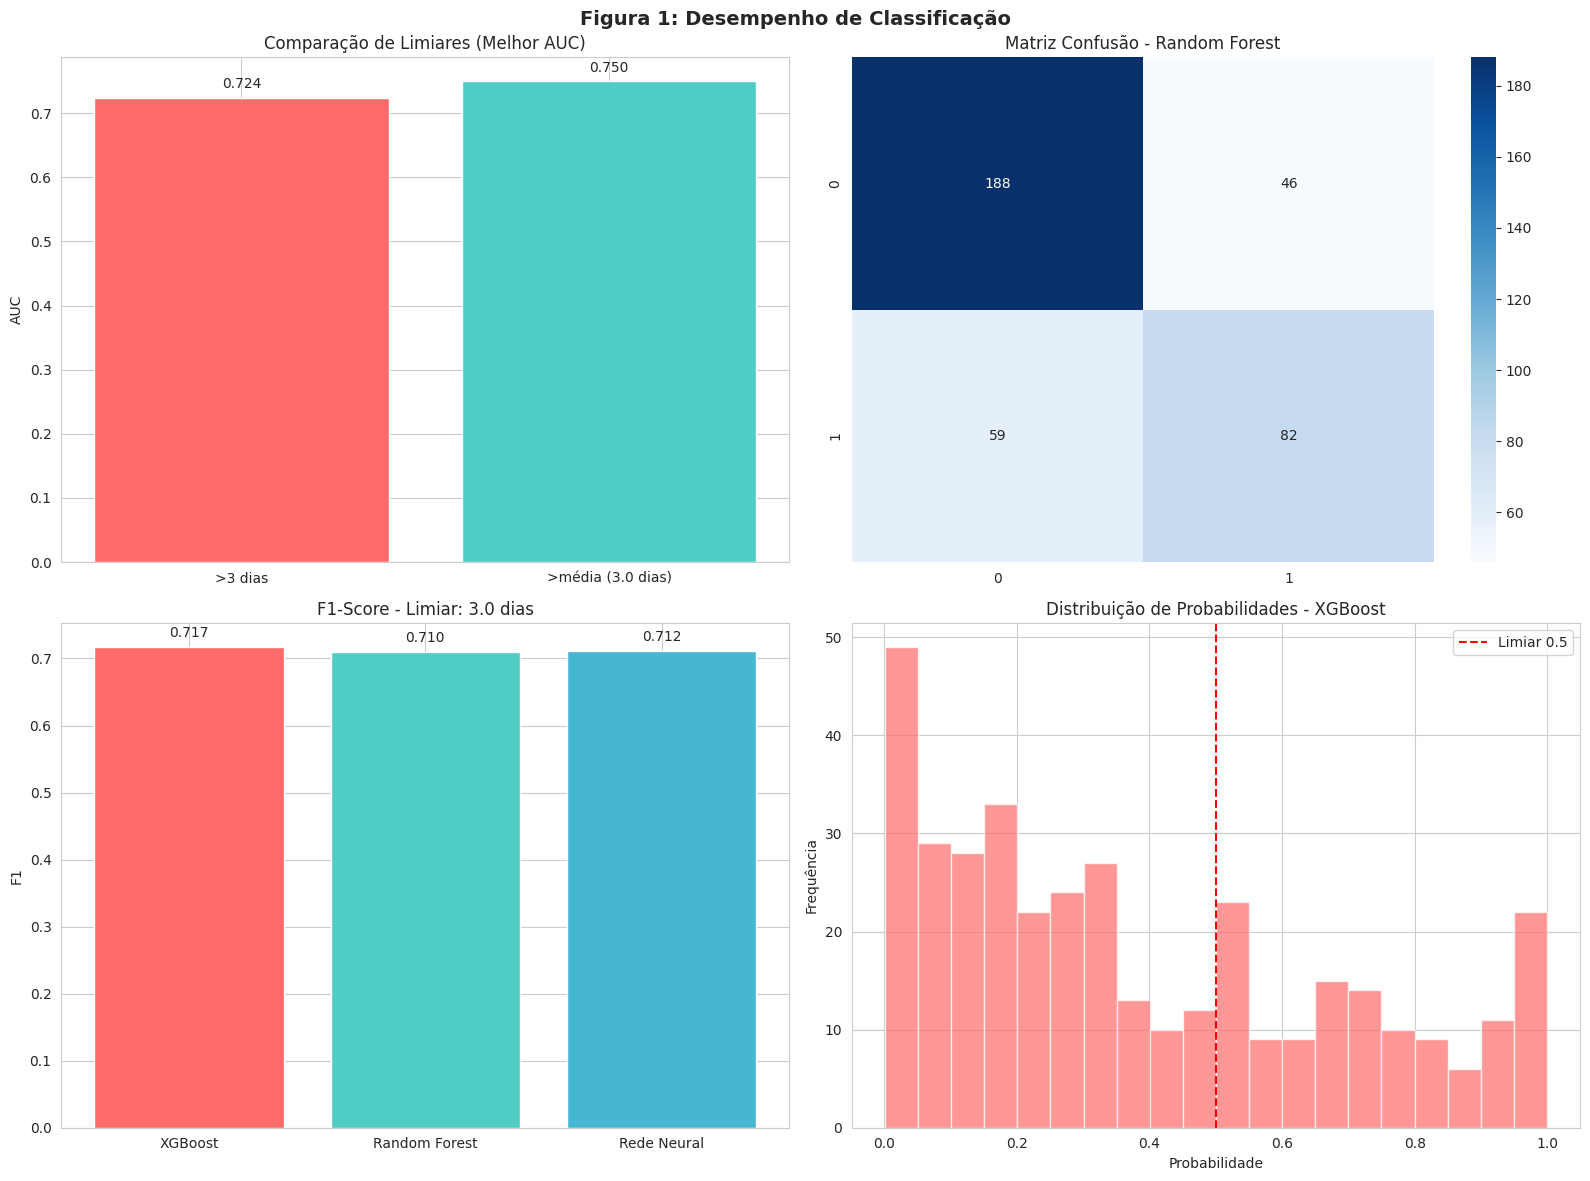

In [10]:
# ## 5. Gerar 5 Figuras Otimizadas para Revista

# %%
print("\n🎨 Gerando figuras...")

# Figura 1: Desempenho de Classificação + Comparação de Limiares
fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle('Figura 1: Desempenho de Classificação', fontsize=14, fontweight='bold')

# Comparação de AUC entre limiares
axes[0,0].bar(['>3 dias', f'>média ({media_dias:.1f} dias)'], 
              [result_3_dias['melhor_auc'], result_media['melhor_auc']], 
              color=['#FF6B6B', '#4ECDC4'])
axes[0,0].set_title("Comparação de Limiares (Melhor AUC)")
axes[0,0].set_ylabel("AUC")
for i, v in enumerate([result_3_dias['melhor_auc'], result_media['melhor_auc']]):
    axes[0,0].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')

# Matriz de Confusão (melhor modelo)
cm = confusion_matrix(class_result['y_test'], class_result['y_pred_xgb'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title(f"Matriz Confusão - {class_result['melhor_modelo']}")

# F1-Score dos modelos (limiar escolhido)
models = list(class_result['metrics'].keys())
f1s = [class_result['metrics'][m][1] for m in models]
axes[1,0].bar(models, f1s, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1,0].set_title(f"F1-Score - Limiar: {limiar_escolhido:.1f} dias")
axes[1,0].set_ylabel("F1")
for i, v in enumerate(f1s):
    axes[1,0].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')

# Distribuição de probabilidades
axes[1,1].hist(class_result['y_proba_xgb'], bins=20, alpha=0.7, color='#FF6B6B')
axes[1,1].axvline(0.5, color='red', linestyle='--', label='Limiar 0.5')
axes[1,1].set_title("Distribuição de Probabilidades - XGBoost")
axes[1,1].set_xlabel("Probabilidade")
axes[1,1].set_ylabel("Frequência")
axes[1,1].legend()

plt.tight_layout()
plt.savefig("fig1_classificacao.png", dpi=300, bbox_inches='tight')
plt.show()


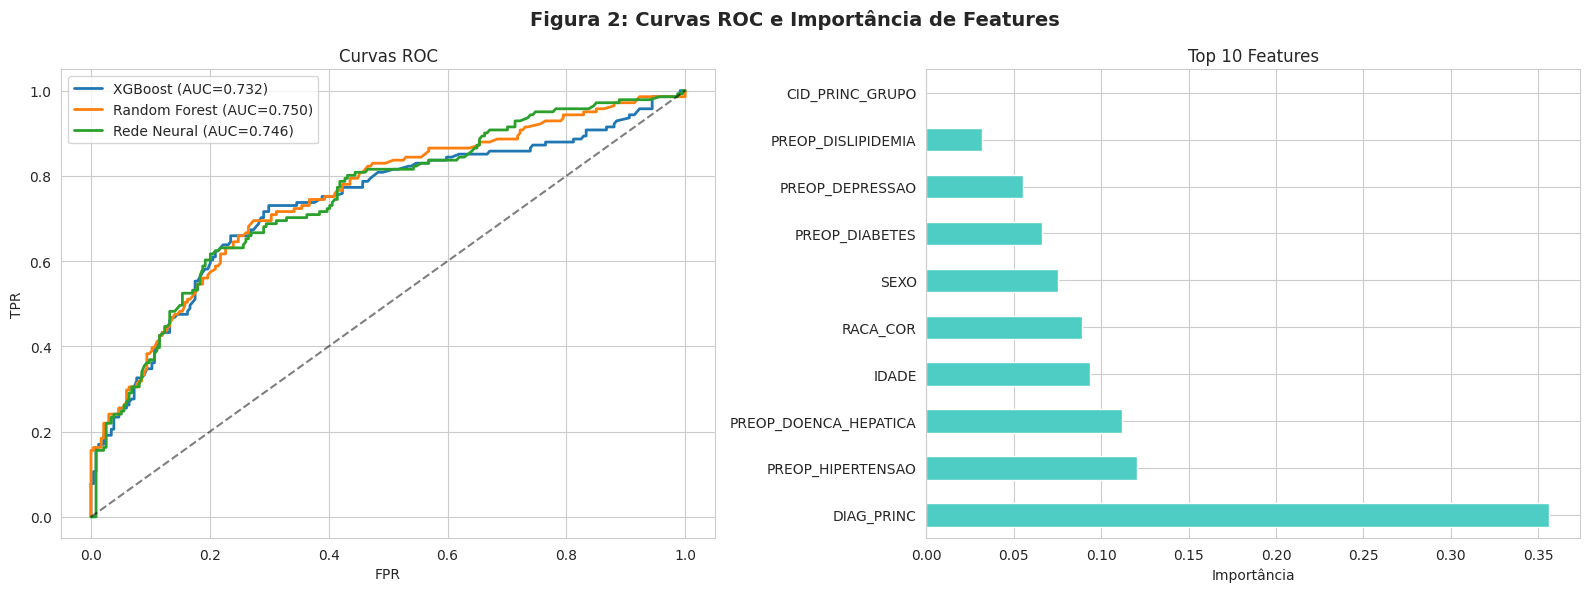

In [20]:
# Figura 2: Curvas ROC + Importância de Features
fig2, axes = plt.subplots(1, 2, figsize=(16, 6))
fig2.suptitle('Figura 2: Curvas ROC e Importância de Features', fontsize=14, fontweight='bold')

# Curvas ROC
fpr_xgb, tpr_xgb, _ = roc_curve(class_result['y_test'], class_result['y_proba_xgb'])
fpr_rf, tpr_rf, _ = roc_curve(class_result['y_test'], class_result['y_proba_rf'])
fpr_nn, tpr_nn, _ = roc_curve(class_result['y_test'], class_result['y_proba_nn'])

axes[0].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={class_result["metrics"]["XGBoost"][0]:.3f})', linewidth=2)
axes[0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={class_result["metrics"]["Random Forest"][0]:.3f})', linewidth=2)
axes[0].plot(fpr_nn, tpr_nn, label=f'Rede Neural (AUC={class_result["metrics"]["Rede Neural"][0]:.3f})', linewidth=2)
axes[0].plot([0,1], [0,1], 'k--', alpha=0.5)
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].set_title('Curvas ROC')
axes[0].legend()
axes[0].grid(True)

# Importância de Features
if hasattr(class_result['model_xgb'], 'feature_importances_'):
    feat_imp = pd.Series(class_result['model_xgb'].feature_importances_, index=X.columns).nlargest(10)
    feat_imp.plot(kind='barh', ax=axes[1], color='#4ECDC4')
    axes[1].set_title('Top 10 Features')
    axes[1].set_xlabel('Importância')

plt.tight_layout()

plt.savefig("fig2_roc_features.png", dpi=300, bbox_inches='tight')
plt.show()

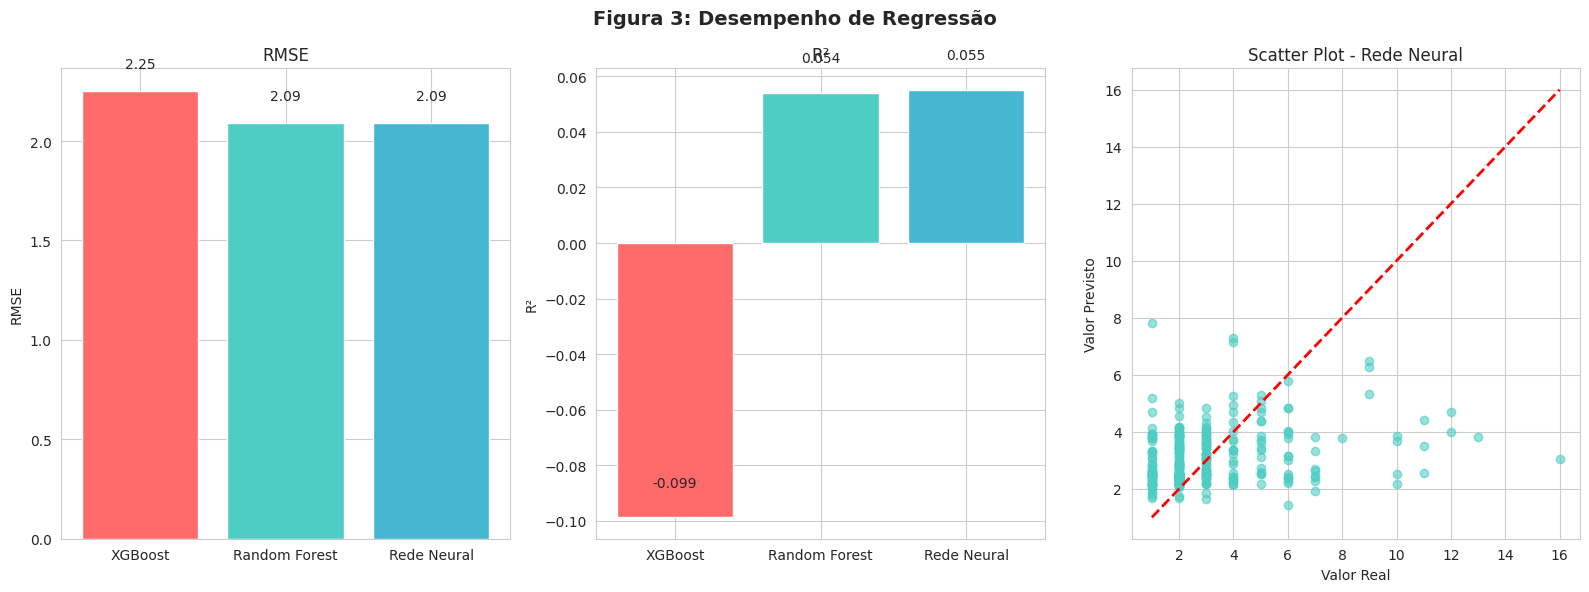

In [19]:
# Figura 3: Desempenho de Regressão
fig3, axes = plt.subplots(1, 3, figsize=(16, 6))
fig3.suptitle('Figura 3: Desempenho de Regressão', fontsize=14, fontweight='bold')

# RMSE
models_reg = list(metrics_reg.keys())
rmses = [metrics_reg[m][0] for m in models_reg]
axes[0].bar(models_reg, rmses, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title("RMSE")
axes[0].set_ylabel("RMSE")
for i, v in enumerate(rmses):
    axes[0].text(i, v + 0.1, f"{v:.2f}", ha='center', va='bottom')

# R²
r2s = [metrics_reg[m][2] for m in models_reg]
axes[1].bar(models_reg, r2s, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_title("R²")
axes[1].set_ylabel("R²")
for i, v in enumerate(r2s):
    axes[1].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')

# Scatter Plot (melhor modelo de regressão)
melhor_modelo_reg = max(metrics_reg.keys(), key=lambda k: metrics_reg[k][2])  # maior R²
if melhor_modelo_reg == 'XGBoost':
    y_pred_best = y_pred_xgb_reg
elif melhor_modelo_reg == 'Random Forest':
    y_pred_best = y_pred_rf_reg
else:
    y_pred_best = y_pred_nn_reg

axes[2].scatter(y_test_reg, y_pred_best, alpha=0.6, color='#4ECDC4')
axes[2].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[2].set_xlabel("Valor Real")
axes[2].set_ylabel("Valor Previsto")
axes[2].set_title(f"Scatter Plot - {melhor_modelo_reg}")

plt.tight_layout()
plt.savefig("fig3_regressao.png", dpi=300, bbox_inches='tight')
plt.show()


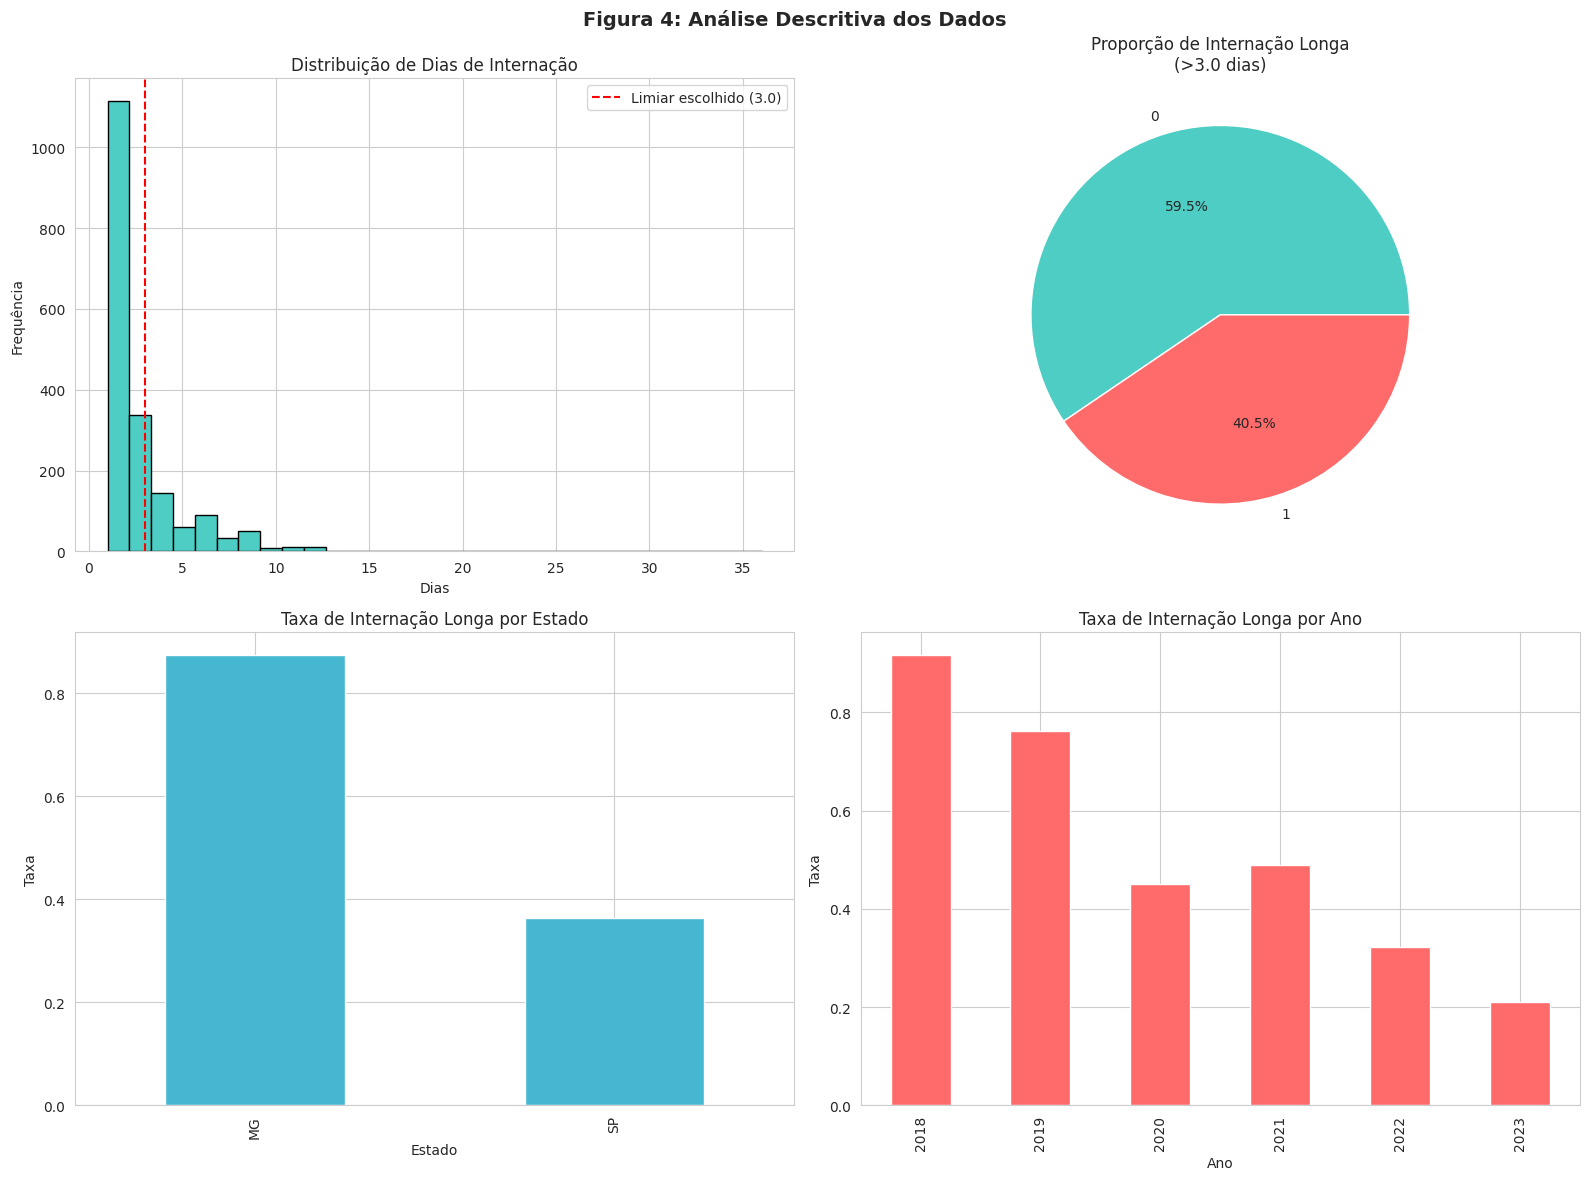

In [13]:
# Figura 4: Análise Descritiva
fig4, axes = plt.subplots(2, 2, figsize=(16, 12))
fig4.suptitle('Figura 4: Análise Descritiva dos Dados', fontsize=14, fontweight='bold')

# Distribuição de dias de internação
axes[0,0].hist(df['DIAS_PERM'], bins=30, color='#4ECDC4', edgecolor='black')
axes[0,0].axvline(limiar_escolhido, color='red', linestyle='--', label=f'Limiar escolhido ({limiar_escolhido:.1f})')
axes[0,0].set_title("Distribuição de Dias de Internação")
axes[0,0].set_xlabel("Dias")
axes[0,0].set_ylabel("Frequência")
axes[0,0].legend()

# Proporção de internação longa (limiar escolhido)
df[alvo_classificacao].value_counts().plot.pie(
    ax=axes[0,1], autopct='%1.1f%%', colors=['#4ECDC4', '#FF6B6B']
)
axes[0,1].set_title(f"Proporção de Internação Longa\n(>{limiar_escolhido:.1f} dias)")
axes[0,1].set_ylabel("")

# Taxa por estado
taxa_estado = df.groupby('ESTADO_ORIGEM')[alvo_classificacao].mean()
taxa_estado.plot(kind='bar', ax=axes[1,0], color='#45B7D1')
axes[1,0].set_title("Taxa de Internação Longa por Estado")
axes[1,0].set_xlabel("Estado")
axes[1,0].set_ylabel("Taxa")

# Taxa por ano
taxa_ano = df.groupby('ANO_CMPT')[alvo_classificacao].mean()
taxa_ano.plot(kind='bar', ax=axes[1,1], color='#FF6B6B')
axes[1,1].set_title("Taxa de Internação Longa por Ano")
axes[1,1].set_xlabel("Ano")
axes[1,1].set_ylabel("Taxa")

plt.tight_layout()
plt.savefig("fig4_descritiva.png", dpi=300, bbox_inches='tight')
plt.show()
